# Layered Model - Comparison

### For the model, see the notebook BlockModel.ipynb

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Helper routines

In [3]:
def extract_lines(name):
    """Get data <name>."""
    inp = xr.load_dataset(name, engine='h5netcdf')
    print_attributes(inp)
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out


def print_attributes(inp):
    """Print info from modeller."""
    for key in ['runtime', 'n_procs', 'max_ram',
                'n_cells', 'n_nodes', 'n_dof', 'extent',
                'min_vol', 'max_vol', 'machine',
                'version', 'date']:
        print(f"{key:10} : {inp.attrs[key]}")


def get_pos_neg(resp, off, min_off):
    """Separate positive and negative values, enforce min_off."""
    resp_pos = np.array([x if x > 0 else np.nan for x in resp])
    resp_neg = np.array([-x if x < 0 else np.nan for x in resp])

    resp_pos[off < min_offset] = np.nan
    resp_neg[off < min_offset] = np.nan

    return resp_pos, resp_neg

## Load info and data

### Survey info

In [4]:
ds = xr.load_dataset('block_model_and_survey.nc', engine='h5netcdf')
rec_x = ds.x[::2].data
rec_y = ds.attrs['rec_y']

### Load data, compute relative error

In [5]:
data = {
    'empymod': 'empymod',
    'emg3d': 'emg3d',
    'custEM': 'custEM_p2',
    'PETGEM': 'petgem',
    'SimPEG': 'simpeg',
}

# Load all data
for key, value in data.items():
    print(f"\n= {key} =\n-----------")
    data[key] = extract_lines(f"results/layered_{value}.nc")
    
# Compute relative error (%)
error = {}
aerror = {}
for name in ['emg3d', 'custEM', 'PETGEM', 'SimPEG']:
    re_error = 100*abs((data['empymod'].real - data[name].real)/data['empymod'].real)
    im_error = 100*abs((data['empymod'].imag - data[name].imag)/data['empymod'].imag)
    error[name] = re_error + 1j*im_error
    aerror[name] = 100*abs((np.abs(data['empymod']) - np.abs(data[name]))/np.abs(data['empymod']))


= empymod =
-----------
runtime    : 0 s
n_procs    : 1
max_ram    : 0.005 GiB
n_cells    : N/A
n_nodes    : N/A
n_dof      : N/A
extent     : N/A
min_vol    : N/A
max_vol    : N/A
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 18.04
version    : empymod v2.0.2
date       : 2020-09-02T17:41:47.982563

= emg3d =
-----------
runtime    : 116 s
n_procs    : 1
max_ram    : 0.377 GiB
n_cells    : (256 x 64 x 96) - 1572864
n_nodes    : N/A
n_dof      : 4813216
extent     : x = -57087.8-65201.2; y = -51967.8-51967.8; z = -35514.7-65482.0
min_vol    : 1000000.0
max_vol    : 2302175527498.2
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 18.04
version    : emg3d v0.12.0
date       : 2020-09-04T10:57:50.304951

= custEM =
-----------
runtime    : 118 s
n_procs    : 24
max_ram    : 97.8 GiB
n_cells    : 242147
n_nodes    : 39288
n_dof      : 3063648
extent     : x = -100000 - 100000; y = -100000 - 100000; z = -100000 - 100000
min_vol    : 125000

## Comparison Plots

In [6]:
# We plot data at offsets < min_offset
min_offset = 500

# Markers for scatter plots
marker = ['*', 'v', '^', 'o']
ms = [4, 3, 3, 3]

# Properties we loop over or use in loops
reim = [np.real, np.imag, np.abs]
lines = ["Inline", "Broadside"]
color = ['k', '0.6']

<IPython.core.display.Javascript object>


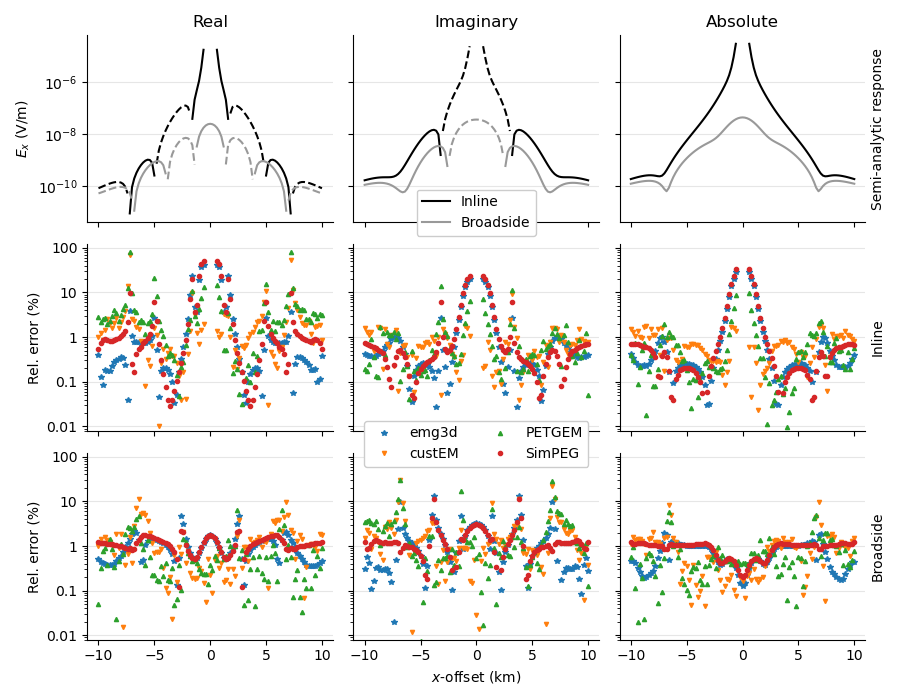

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(9, 7), sharex=True, sharey='row')
((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = axs

# # (A) Plot semi-analytical responses # #

# Plot over real, imaginary
for i, ax in enumerate(axs[0, :]):
    
    # Title
    ax.set_title(['Real', 'Imaginary', 'Absolute'][i])
    
    # Loop over inline, broadside
    for iy, line in enumerate(lines):
        
        # Get offset
        off = np.sqrt(rec_x**2 + rec_y[iy+1]**2)
    
        # Get positive and negative values
        resp_pos, resp_neg = get_pos_neg(
            reim[i](data['empymod'][:, iy+1]), off, min_offset)

        # Plot them
        ax.plot(rec_x/1e3, resp_pos, '-', c=color[iy], label=line)
        ax.plot(rec_x/1e3, resp_neg, '--', c=color[iy])

    # Axis labeling, scaling, etc
    ax.set_yscale('log')
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.grid(axis='y', c='0.9')
    if i == 2:
        ax.set_ylim(ax1.get_ylim())
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('Semi-analytic response')
    elif i == 0:
        ax.set_ylabel("$E_x$ (V/m)")

    
# # (B) Plot relative error # #

# Plot over ({Re;Im;Abs}-{inline;broadside})
for i, ax in enumerate(axs[1:, :].ravel()):
           
    # Loop over codes
    for ii, name in enumerate(error.keys()):
        
        # Set errors at offsets < min_offset to NaN
        error[name][off < min_offset, iy] = np.nan + 1j*np.nan

        # Plot
        if i % 3 == 2:
            perror = aerror[name][:, i//3+1]
        else:
            perror = reim[i%2](error[name][:, i//3+1])
            
        # Set errors at offsets < min_offset to NaN
        off = np.sqrt(rec_x**2 + rec_y[i // 3 + 1]**2)
        perror[off < min_offset] = np.nan
            
        ax.plot(rec_x/1e3, perror, f'C{ii}{marker[ii]}', ms=ms[ii], label=name)

    # Axis labeling, scaling, etc
    ax.set_yscale('log')
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.set_ylim([8e-3, 120])
    ax.set_yticks([0.01, 0.1, 1, 10, 100])
    ax.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
    ax.grid(axis='y', c='0.9')
    if i in [2, 5]:
        ax.yaxis.set_label_position("right")
        ax.set_ylabel(lines[i//3])
    elif i in [0, 3]:
        ax.set_ylabel('Rel. error (%)')

# Switch off spines
for ax in axs.ravel():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
axs[2, 1].set_xlabel('$x$-offset (km)')

fig.tight_layout()

# Legends
ax2.legend(bbox_to_anchor=(0.5, 0.05), loc='center', framealpha=1)
ax8.legend(bbox_to_anchor=(0.5, 1.05), loc='center', framealpha=1, ncol=2)

fig.savefig(f'../manuscript/figures/results-layered.pdf', bbox_inches='tight')   
fig.show()

In [8]:
import scooby
scooby.Report()

--------------------------------------------------------------------------------
  Date: Sun Oct 11 16:53:25 2020 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49)
  [GCC 7.5.0]

             numpy : 1.19.1
             scipy : 1.5.2
           IPython : 7.18.1
        matplotlib : 3.3.1
            scooby : 0.5.6
--------------------------------------------------------------------------------